## 1- Importing Packages

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import KNNImputer

## 2- Import Dataset

In [60]:
df = pd.read_csv(r"B:\Code\DMTA\clustering\Mall_Customers.csv")

## 3- Preprocessing

In [61]:
# EDA.1 -> Checking rows, columns and name of columns
rows, columns = df.shape
print(f'rows: {rows} \n columns: {columns}')
print(df.columns)

rows: 203 
 columns: 5
Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


In [62]:
# EDA.2 -> Getting statistics summary from data set
df.describe(include="all")

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,203.000000,203,199.000000,202,203.000000
unique,NaN,2,NaN,65,NaN
top,NaN,Female,NaN,54,NaN
freq,NaN,112,NaN,12,NaN
mean,100.615764,NaN,38.688442,NaN,58.507389
std,58.082650,NaN,13.875835,NaN,93.449323
min,1.000000,NaN,18.000000,NaN,1.000000
25%,50.500000,NaN,28.500000,NaN,33.000000
50%,101.000000,NaN,36.000000,NaN,50.000000
75%,150.500000,NaN,48.500000,NaN,72.500000


### As you can see, there are some spanding scores more than 100(max is 1000).

In [63]:
# Cleaning.1 -> Let's ensure that values in the "Spending Score (1-100)" column do not exceed 100
df["Spending Score (1-100)"] = df["Spending Score (1-100)"].clip(upper=100)

In [64]:
# EDA.3 -> Getting a preview from data set
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15,39
1,2,Male,21.0,??,81
2,3,Female,20.0,16,6
3,4,Female,23.0,16,77
4,5,Female,31.0,17,40


In [65]:
# Cleaning.2 -> Replacing ?? with NaN values
df.replace("??", np.NaN, inplace=True)

In [66]:
# EDA.4 -> Checking data types
df.dtypes

CustomerID                  int64
Gender                     object
Age                       float64
Annual Income (k$)         object
Spending Score (1-100)      int64
dtype: object

In [67]:
# Cleaning.3 -> Changing the type of Annual Income column
df[['Annual Income (k$)', 'Age']] = df[['Annual Income (k$)', 'Age']].astype('Int64')

In [68]:
# Cleaning.4 -> Dropping unnecessary columns
df.drop(["CustomerID"], axis=1, inplace=True)

In [69]:
# EDA.5 -> Checking if there are duplicates
df.duplicated().sum()

3

In [70]:
# Cleaning.5 -> dropping duplicates
df.drop_duplicates(inplace=True)

In [71]:
df.dtypes

Gender                    object
Age                        Int64
Annual Income (k$)         Int64
Spending Score (1-100)     int64
dtype: object

In [72]:
# EDA.6 -> Checking pairwise correlation of columns
df.corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.020045,-0.323191
Annual Income (k$),-0.020045,1.000000,0.047007
Spending Score (1-100),-0.323191,0.047007,1.000000


In [73]:
# Defining a df without NaN values so we can draw plots on it. 
df_withount_nan = df.dropna()

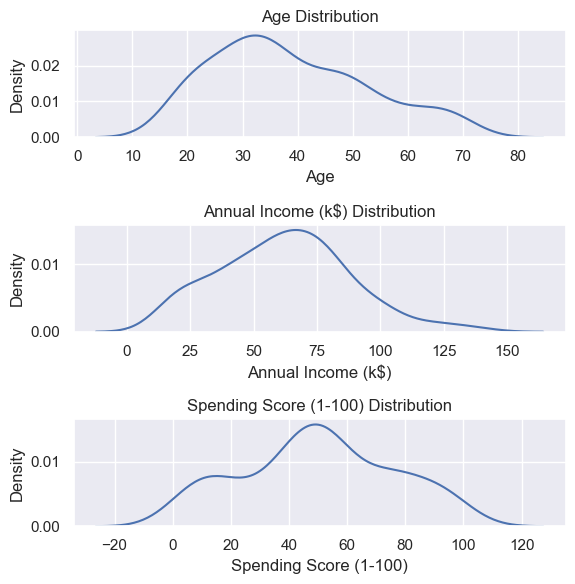

In [79]:
# EDA.7 -> KDE diagrams for columns with continous values
continous_columns = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

for i, col in enumerate(continous_columns):
    plt.subplot(3, 1, i+1)
    sns.set_theme(rc={'figure.figsize':(4, 4)})
    sns.kdeplot(df_withount_nan[col])
    plt.title(f"{col} Distribution")

plt.tight_layout()
plt.show()

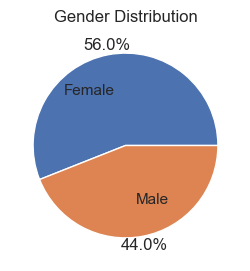

In [75]:
# EDA.8 -> Pie chart for columns with discrete values
Gender_values = df["Gender"].value_counts()
plt.pie(Gender_values, labels=Gender_values.index, autopct='%1.1f%%',
           pctdistance=1.1, labeldistance=.6)
plt.title('Gender Distribution')
plt.show()

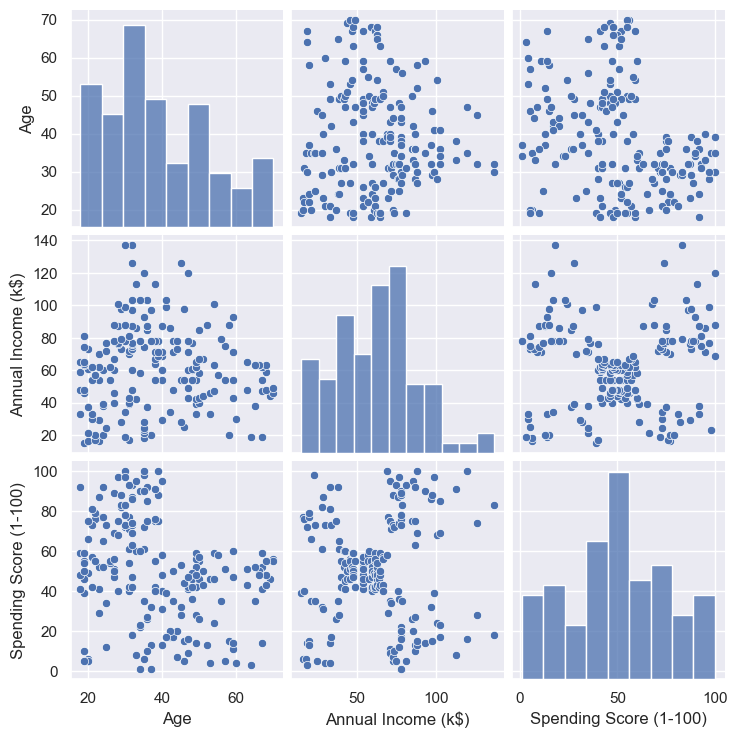

In [76]:
# EDA.9 -> Pair plot to see the pairwise relationships between features 
# and can help identify any visible clusters or patterns.

sns.set_theme(rc={'figure.figsize':(8, 8)})
sns.pairplot(df_withount_nan)
plt.show()

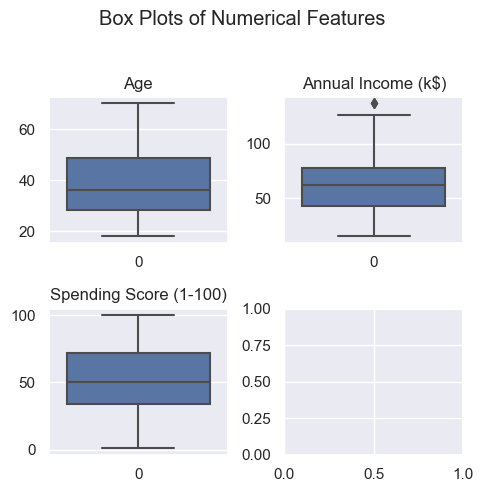

In [82]:
# EDA.10 -> Box plots 
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
fig.suptitle('Box Plots of Numerical Features')

for i, col in enumerate(continous_columns):
    ax = axs[i // 2, i % 2]
    sns.boxplot(data=df_withount_nan[col], ax=ax)
    ax.set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

In [84]:
# Cleaning.6 -> detecting outliers using Z Score
threshold = 3
    
df_withount_nan["income_z_score"] = df_withount_nan.groupby(['Gender', 'Age'])['Annual Income (k$)'].transform(
    lambda x: (x - x.mean()) / x.std())

df_withount_nan['income_z_score'].fillna(0, inplace=True)

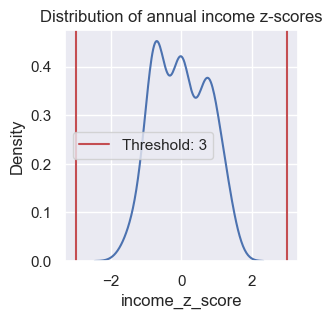

In [85]:
# Visualize the distribution of annual income z-scores
sns.set_theme(rc={'figure.figsize':(3, 3)})
sns.kdeplot(df_withount_nan['income_z_score'])

# Indicating the threshold
plt.axvline(threshold, color='r', label=f'Threshold: {threshold}')
plt.axvline(-threshold, color='r')

plt.title("Distribution of annual income z-scores")
plt.legend()
plt.show()

In [87]:
df_withount_nan['income_outlier'] = False
df_withount_nan.loc[abs(df_withount_nan['income_outlier']) > threshold, 'income_outlier'] = True

In [88]:
# As you can see, there is no outlier detected
df_withount_nan["income_outlier"].value_counts()

False    190
Name: income_outlier, dtype: int64

In [89]:
# Cleaning.7 -> Label Encoding
encoder = preprocessing.LabelEncoder()
df["Gender"] = encoder.fit_transform(df["Gender"])

In [90]:
# Normalization
scale = preprocessing.StandardScaler().fit(df)
x = scale.fit_transform(df)

In [91]:
x.shape

(200, 4)

In [92]:
# EDA.11 -> Checking if there are missing values
df.isnull().sum()

Gender                    0
Age                       4
Annual Income (k$)        6
Spending Score (1-100)    0
dtype: int64

In [93]:
# Cleaning.8 -> Imputing missing values using KNN
knn_imp = KNNImputer(n_neighbors=5)
imputed_x = knn_imp.fit_transform(x)
x = imputed_x

In [94]:
np.isnan(x).sum()

0

## 4- Elbow Method

### interia measures how well a dataset is clustered by measuring the distance between each data point and its centroid

C:\Users\saras\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


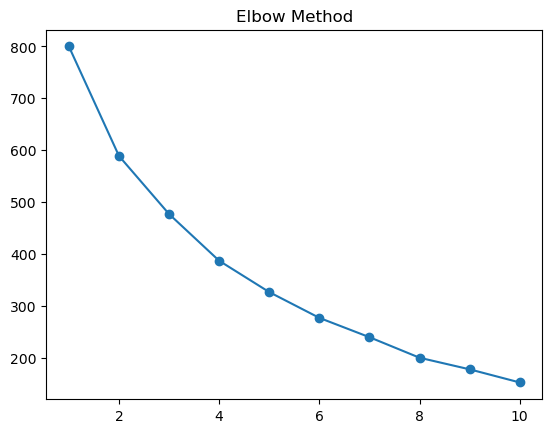

In [11]:
interias = []
for i in range(1, 11):
    k_means = KMeans(n_clusters=i, init="k-means++", n_init=12)
    k_means.fit(x)
    interias.append(k_means.inertia_)
plt.plot(range(1, 11), interias, marker="o")
plt.title("Elbow Method")
plt.show()

### with the help of the elbow method, it is concluded that the optimal number of clusters for the given data and clustering technique is 4 or 5.

## 5- Reducing the dimensionality of the Data

In [12]:
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(x)
reduced_X = pd.DataFrame(reduced_X)
reduced_X.columns = ['P1', 'P2']

In [14]:
silhouette_scores = []

## 6- Applying K-Means with 4 clusters and visualizing the clusters:

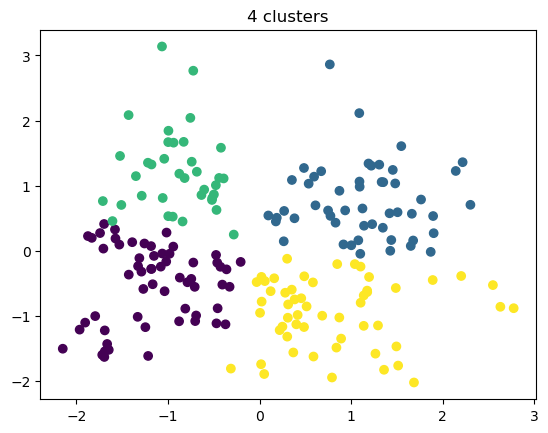

In [15]:
k_means = KMeans(n_clusters=4)
k_means.fit(reduced_X)
silhouette_average_score = silhouette_score(reduced_X, k_means.predict(reduced_X))
silhouette_scores.append(silhouette_average_score)
plt.scatter(reduced_X["P1"], reduced_X["P2"], c=k_means.predict(reduced_X))
plt.title("4 clusters")
plt.show()

## 7- Applying K-Means with 5 clusters and visualizing the clusters:

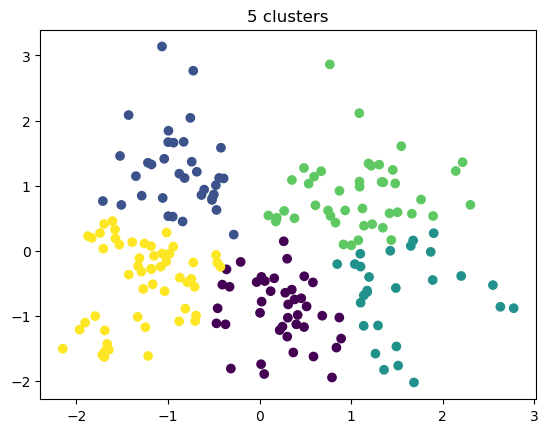

In [16]:
k_means = KMeans(n_clusters=5)
k_means.fit(reduced_X)
silhouette_average_score = silhouette_score(reduced_X, k_means.predict(reduced_X))
silhouette_scores.append(silhouette_average_score)
plt.scatter(reduced_X["P1"], reduced_X["P2"], c=k_means.predict(reduced_X))
plt.title("5 clusters")
plt.show()

## 8- Plotting a bar graph to compare silhouette scores

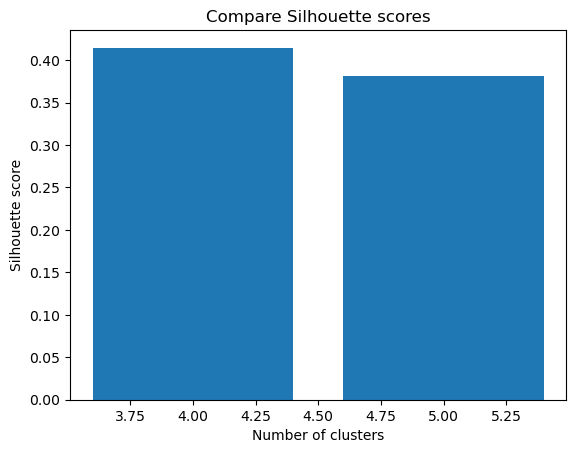

In [18]:
plt.bar(range(4, 6), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title("Compare Silhouette scores")
plt.show()

### So the optimal number of clusters for the given data and clustering technique is 4

## 9- Fit the K-Means model with 4 clusters:

In [19]:
k_means = KMeans(n_clusters=4)
k_means.fit(x)
df["Labels"] = k_means.labels_